In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn import preprocessing
from collections import Counter
import glob
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

In [4]:
sys.path.append(r"A:\US_CornSoy_ClassificationYield\Scripts\US_CornSoy_ClassificationYield")
from utils import *

In [809]:
from importlib import reload
reload(sys.modules['utils'])
from utils import *

# Read data

In [5]:
#path_csb22_IL = r"C:\Users\tangz\Desktop\US_CornSoy_ClassificationYield\GeoData\Vectors\csb_IL_2022.shp"
path_csb22 = r"A:\US_CornSoy_ClassificationYield\Geodata\Vectors\csb_IL_2022.shp"
csb22 = gpd.read_file(path_csb22)

In [6]:
dir_usda = r"A:\US_CornSoy_ClassificationYield\TabularData"
usda_area = pd.read_csv(os.path.join(dir_usda, "US_County_CornSoy_Area.csv"))

# Preprocess 

## USDA Area

In [7]:
state_area = usda_area[usda_area['Geo Level'] == 'STATE']
cnty_area = usda_area[usda_area['Geo Level'] == 'COUNTY']
#SUBSET COLUMNS
state_area = state_area[['Year', 'State', 'State ANSI', 'Commodity', 'Value']]
cnty_area = cnty_area[['Year', 'State', 'State ANSI', 'County', 'County ANSI', 'Commodity', 'Value']]
#Rename Columns
state_area.columns = ['Year', 'State', 'StateANSI', 'Crop', 'AreaAcres_usda']
cnty_area.columns = ['Year', 'State', 'StateANSI', 'County', 'CntyANSI', 'Crop', 'AreaAcres_usda']
#remove rows whose CntyANSI column is NaN
cnty_area = cnty_area.dropna(subset=['CntyANSI']) 
#convert CntyANSI to int with no decimal, and fill with leading zeros to make 3 digits
cnty_area['CntyANSI'] = cnty_area['CntyANSI'].astype(int).astype(str).str.zfill(3)
#convert State and County and Crop column to be uppercase for only the first letter
cnty_area['State'] = cnty_area['State'].str.title()
cnty_area['County'] = cnty_area['County'].str.title()
cnty_area['Crop'] = cnty_area['Crop'].str.title()
state_area['State'] = state_area['State'].str.title()
state_area['Crop'] = state_area['Crop'].str.title()
#remove comma in AreaAcres_usda column, and convert AreaAcres_usda to float
cnty_area['AreaAcres_usda'] = cnty_area['AreaAcres_usda'].str.replace(',', '').astype(float)
state_area['AreaAcres_usda'] = state_area['AreaAcres_usda'].str.replace(',', '').astype(float)
#convert Soybeans to Soybean
cnty_area['Crop'] = cnty_area['Crop'].str.replace('Soybeans', 'Soybean')
state_area['Crop'] = state_area['Crop'].str.replace('Soybeans', 'Soybean')

## CSB data

In [8]:
#subset columns 
csb22 = csb22[['CSBID','CSBACRES','R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22', 'CNTY','CNTYFIPS', 'STATEASD']]
#set CNTYFIPS to string
csb22['CNTYFIPS'] = csb22['CNTYFIPS'].astype(str)
csb22['STATEASD'] = csb22['STATEASD'].astype(str)
csb22.head()
# reclassify R15-R22 to three classes 
def tri_classes(value):
    if value == 1:
        return 'Corn'
    elif value == 5:
        return 'Soybean'
    else:
        return 'Other'
csb22[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']] = csb22[['R15', 'R16', 'R17', 'R18', 'R19','R20', 'R21', 'R22']].applymap(tri_classes)

In [9]:
print(csb22.shape)
print(Counter(csb22['R22']).most_common(5))
print(Counter(csb22['R21']).most_common(5))
print(Counter(csb22['R20']).most_common(5))
print(Counter(csb22['R19']).most_common(5))
print(Counter(csb22['R18']).most_common(5))
print(Counter(csb22['R17']).most_common(5))
print(Counter(csb22['R16']).most_common(5))
print(Counter(csb22['R15']).most_common(5))

(653148, 13)
[('Soybean', 306682), ('Corn', 277308), ('Other', 69158)]
[('Soybean', 298151), ('Corn', 289765), ('Other', 65232)]
[('Corn', 304472), ('Soybean', 289643), ('Other', 59033)]
[('Soybean', 268495), ('Corn', 255585), ('Other', 129068)]
[('Soybean', 294920), ('Corn', 283479), ('Other', 74749)]
[('Soybean', 292525), ('Corn', 290433), ('Other', 70190)]
[('Corn', 300714), ('Soybean', 271237), ('Other', 81197)]
[('Corn', 297572), ('Soybean', 258952), ('Other', 96624)]


## Compare with USDA Area 

- Need to change state name in plots when copying the code to different states

In [10]:
agg_corn22_cnty = csb22[csb22['R22'] == 'Corn'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES':'sum'}).reset_index()
agg_soy22_cnty = csb22[csb22['R22'] == 'Soybean'].groupby(['CNTYFIPS', 'CNTY']).agg({'CSBACRES':'sum'}).reset_index()
agg_corn22_cnty.head()

,CNTYFIPS,CNTY,CSBACRES
0,001,Adams,143505.067917
1,003,Alexander,4687.555692
2,005,Bond,68344.472991
3,007,Boone,71288.880834
4,009,Brown,33213.755483


In [11]:
# Need to change the state name 
compare_corn22_cnty = pd.merge(agg_corn22_cnty, cnty_area[(cnty_area.Crop == 'Corn')&(cnty_area.Year==2022)&(cnty_area.State=='Illinois')], how = "inner", left_on=['CNTYFIPS','CNTY'], right_on=['CntyANSI','County'])
compare_soy22_cnty = pd.merge(agg_soy22_cnty, cnty_area[(cnty_area.Crop == 'Soybean')&(cnty_area.Year==2022)&(cnty_area.State=='Illinois')], how = "inner", left_on=['CNTYFIPS','CNTY'], right_on=['CntyANSI','County'])

r2 (corn)=  0.9981033286148491
Total area of corn in CSB =  9317407.905474458
Total area of corn in USDA =  9252400.0
Diffrence of total area of corn in CSB and USDA =  65007.90547445789
Percentage of total area of corn in CSB and USDA =  0.007026058695523096
r2 (soybean)=  0.9689286203125035
Total area of soybean in CSB =  9095841.661116943
Total area of soybean in USDA =  9301900.0
Diffrence of total area of soybean in CSB and USDA =  -206058.33888305724
Percentage of total area of soybean in CSB and USDA =  -0.02215228489696269


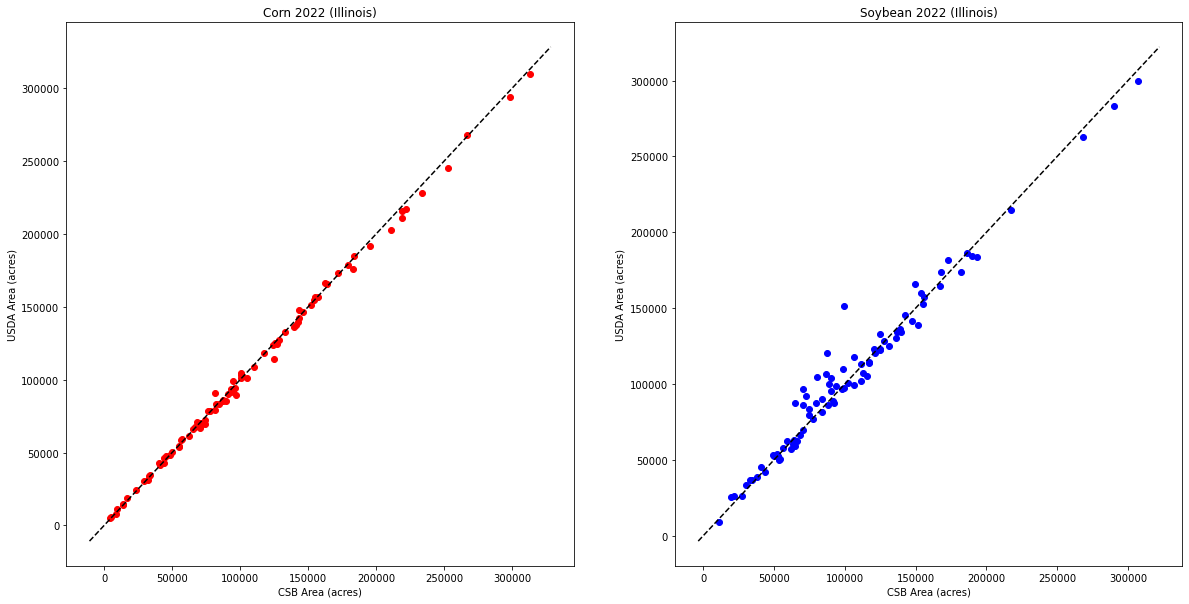

In [12]:
# Plot the comparison of CSBACRES and AreaAcres_usda for corn and soybean in two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(compare_corn22_cnty['CSBACRES'], compare_corn22_cnty['AreaAcres_usda'], color='red')
ax1.set_title('Corn 2022 (Illinois)')
ax1.set_xlabel('CSB Area (acres)')
ax1.set_ylabel('USDA Area (acres)')
#add 1:1 line
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, color='black', linestyle='--')
#calculate and print out the r2
r2 = np.corrcoef(compare_corn22_cnty['CSBACRES'], compare_corn22_cnty['AreaAcres_usda'])[0,1]**2
print('r2 (corn)= ', r2)
#Calculate the total area of corn in CSB and USDA
print('Total area of corn in CSB = ', compare_corn22_cnty['CSBACRES'].sum())
print('Total area of corn in USDA = ', compare_corn22_cnty['AreaAcres_usda'].sum())
#Calculate the diffrence and percentage of the total area of corn in CSB and USDA
print('Diffrence of total area of corn in CSB and USDA = ', compare_corn22_cnty['CSBACRES'].sum() - compare_corn22_cnty['AreaAcres_usda'].sum())
print('Percentage of total area of corn in CSB and USDA = ', (compare_corn22_cnty['CSBACRES'].sum() - compare_corn22_cnty['AreaAcres_usda'].sum())/compare_corn22_cnty['AreaAcres_usda'].sum())

ax2.scatter(compare_soy22_cnty['CSBACRES'], compare_soy22_cnty['AreaAcres_usda'], color='blue')
ax2.set_title('Soybean 2022 (Illinois)')
ax2.set_xlabel('CSB Area (acres)')
ax2.set_ylabel('USDA Area (acres)')
#add 1:1 line
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, color='black', linestyle='--')
#calculate and print out the r2
r2 = np.corrcoef(compare_soy22_cnty['CSBACRES'], compare_soy22_cnty['AreaAcres_usda'])[0,1]**2
print('r2 (soybean)= ', r2)
#Calculate the total area of soybean in CSB and USDA
print('Total area of soybean in CSB = ', compare_soy22_cnty['CSBACRES'].sum())
print('Total area of soybean in USDA = ', compare_soy22_cnty['AreaAcres_usda'].sum())
#Calculate the diffrence and percentage of the total area of soybean in CSB and USDA
print('Diffrence of total area of soybean in CSB and USDA = ', compare_soy22_cnty['CSBACRES'].sum() - compare_soy22_cnty['AreaAcres_usda'].sum())
print('Percentage of total area of soybean in CSB and USDA = ', (compare_soy22_cnty['CSBACRES'].sum() - compare_soy22_cnty['AreaAcres_usda'].sum())/compare_soy22_cnty['AreaAcres_usda'].sum())

plt.show()

## GEE Time Series

## 2023

In [696]:
s2_23 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2023_IL.csv')

In [702]:
_, df_interp_2023 = clean_gee(s2_23) #took about 23mins to run 

In [703]:
df_wide_2023 = long_to_wide(df_interp_2023, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2023_IL.csv") #5mins to run

## 2022

In [704]:
s2_22 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2022_IL.csv') #1min

In [705]:
_, df_interp_2022 = clean_gee(s2_22) #took about 38mins to run

In [694]:
# print(df_interp_2021['REP'].quantile(0.01))
# print(df_interp_2021['REP'].quantile(0.99))
# print(df_interp_2022['REP'].quantile(0.01))
# print(df_interp_2022['REP'].quantile(0.99))
# print(df_interp_2023['REP'].quantile(0.01))
# print(df_interp_2023['REP'].quantile(0.99))

700.7625023312044
749.8619590279054
668.4171681904397
784.243084902655
698.9738102714309
744.3910167209439


In [706]:
df_wide_2022 = long_to_wide(df_interp_2022, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2022_IL.csv") #5mins to run 

## 2021

In [707]:
s2_21 = pd.read_csv('A:\\US_CornSoy_ClassificationYield\\GEEData\\s2_ts_2021_IL.csv') #1min

In [708]:
_, df_interp_2021 = clean_gee(s2_21) #took about 23mins to run

In [709]:
df_wide_2021 = long_to_wide(df_interp_2021, Output = True, path_out = r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2021_IL.csv") #5mins to run 

# Pre season Prediction (March Prediction)
Only use the crop rotation data, field area and ASD (location information) from CSB for prediction 

In [13]:
X_5_21, Y_21 = preprocess_csb(csb22, n_var = 5, yr = 21)
X_5_22, Y_22 = preprocess_csb(csb22, n_var = 5, yr = 22)
X_5_23 = preprocess_csb(csb22, n_var = 5, yr = 23)

### Predict 2022

In [14]:
results_pre_22 = ml_model_base(df = csb22, csbdf = csb22, model = 'rf', yr = 22, X = X_5_21, Y = Y_21, test_size = 0, Xnew = X_5_22, Ynew = Y_22)

Accuracy new set:  0.670186542713137
Confusion Matrix new set:  [[198979  24065  54264]
 [ 22944  29397  16817]
 [ 75514  21813 209355]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.133221e+07     1.087936e+07  9.947053e+06    1.059549e+07   

       Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  452851.213374 -648435.900205           4.162482         -6.119924  


In [15]:
results_pre_22

(RandomForestClassifier(random_state=777),
 array([2, 2, 0, ..., 0, 0, 0]),
 0.670186542713137,
 array([[198979,  24065,  54264],
        [ 22944,  29397,  16817],
        [ 75514,  21813, 209355]], dtype=int64),
     CNTYFIPS        CNTY  CornAcres_Pred  CornAcres_Actual
 0        001       Adams   157137.805352     143505.067917
 1        003   Alexander    10214.213195       4687.555692
 2        005        Bond    71440.920712      68344.472991
 3        007       Boone    67385.934498      71288.880834
 4        009       Brown    36562.723309      33213.755483
 ..       ...         ...             ...               ...
 97       195   Whiteside   231803.594762     219369.262428
 98       197        Will   101634.716745      97330.844360
 99       199  Williamson    17856.307071      16637.244185
 100      201   Winnebago    99404.531600      89513.591802
 101      203    Woodford   129781.864511     125543.965929
 
 [102 rows x 4 columns],
     CNTYFIPS        CNTY  SoyAcres_Pred

In [16]:
results_pre_22_lgb = ml_model_base(df = csb22, csbdf = csb22, model = 'lgb', yr = 22, X = X_5_21, Y = Y_21, test_size= 0, Xnew = X_5_22, Ynew = Y_22)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 653148, number of used features: 25
[LightGBM] [Info] Start training from score -0.812734
[LightGBM] [Info] Start training from score -2.303854
[LightGBM] [Info] Start training from score -0.784204
Accuracy new set:  0.7625285540183848
Confusion Matrix new set:  [[231613   9490  36205]
 [ 24280  31011  13867]
 [ 65138   6124 235420]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.138867e+07     1.087936e+07  1.034876e+07    1.059549e+07   

       Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  509309.411148 -246725.705651            4.68143         -2.328592  


### Predict 2023

In [17]:
results_pre_23 = ml_model_base(df = csb22, csbdf = csb22, model = 'rf', yr = 23, X = X_5_22, Y = Y_22, test_size = 0.2, Xnew = X_5_23)

Accuracy test set:  0.6851029625660262
Confusion Matrix test set:  [[38551  3812 13210]
 [ 3944  6510  3455]
 [13235  3479 44434]]


In [48]:
results_pre_23[6]['CornAcres_Pred'].sum()

11032115.834597375

In [49]:
results_pre_23[7]['SoyAcres_Pred'].sum()

10275301.1484327

In [18]:
results_pre_23_lgb = ml_model_base(df = csb22, csbdf = csb22, model = 'lgb', yr = 23, X = X_5_22, Y = Y_22, test_size = 0.2, Xnew = X_5_23)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 653148, number of used features: 25
[LightGBM] [Info] Start training from score -0.856675
[LightGBM] [Info] Start training from score -2.245410
[LightGBM] [Info] Start training from score -0.755992
Accuracy test set:  0.7755262956441858
Confusion Matrix test set:  [[44760  1272  9541]
 [ 4113  6735  3061]
 [10283  1053 49812]]


In [50]:
results_pre_23_lgb[6]['CornAcres_Pred'].sum()

11318339.680170916

In [51]:
results_pre_23_lgb[7]['SoyAcres_Pred'].sum()

10504043.378112974

# Sentinel-2 Only Prediction (June Prediction)
Only Use Sentinel-2 time series data for prediction

In [26]:
# Read preprocessed data back 
df_wide_2021 = pd.read_csv(r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2021_IL.csv")
df_wide_2021['CSBID'] = df_wide_2021['CSBID'].astype(str)
df_wide_2022 = pd.read_csv(r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2022_IL.csv")
df_wide_2022['CSBID'] = df_wide_2022['CSBID'].astype(str)
df_wide_2023 = pd.read_csv(r"A:\US_CornSoy_ClassificationYield\Processed_Data\S2VIs_wide_2023_IL.csv")
df_wide_2023['CSBID'] = df_wide_2023['CSBID'].astype(str)

In [25]:
# Merge with csb22 
csb22_s2_2021 = pd.merge(csb22[['CSBID','R21']], df_wide_2021, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2021['R21'] = csb22_s2_2021['R21'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [27]:
# Merge with csb22 
csb22_s2_2022 = pd.merge(csb22[['CSBID','R22']], df_wide_2022, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2022['R22'] = csb22_s2_2022['R22'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [28]:
# Merge with csb22
csb22_s2_2023 = pd.merge(csb22[['CSBID','R22']], df_wide_2023, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# Encode the R22 column
csb22_s2_2023['R22'] = csb22_s2_2023['R22'].map({'Corn': 0, 'Other': 1, 'Soybean': 2})

In [29]:
X_s2_2021 = csb22_s2_2021.iloc[:, 2:]
Y_s2_2021 = csb22_s2_2021.iloc[:, 1]
X_s2_2022 = csb22_s2_2022.iloc[:, 2:]
Y_s2_2022 = csb22_s2_2022.iloc[:, 1]
X_s2_2023 = csb22_s2_2023.iloc[:, 2:]

## Predict 2022

In [30]:
results_s2_22 = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'rf', yr = 22, X = X_s2_2021, Y = Y_s2_2021, test_size = 0, Xnew = X_s2_2022, Ynew = Y_s2_2022)

Accuracy new set:  0.6215156580110699
Confusion Matrix new set:  [[116332   3154 147172]
 [  7158  43252  17039]
 [ 59086   4835 231969]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   7.592771e+06     1.018812e+07  1.270695e+07    9.913685e+06   

      Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -2.595351e+06  2.793262e+06         -25.474279         28.175819  


In [31]:
results_s2_22

(RandomForestClassifier(random_state=777),
 array([2, 2, 2, ..., 1, 0, 0], dtype=int64),
 0.6215156580110699,
 array([[116332,   3154, 147172],
        [  7158,  43252,  17039],
        [ 59086,   4835, 231969]], dtype=int64),
     CNTYFIPS        CNTY  CornAcres_Pred  CornAcres_Actual
 0        001       Adams    33563.383498     143505.067917
 1        003   Alexander    12116.982961       4687.555692
 2        005        Bond    44068.237083      68344.472991
 3        007       Boone    17897.314078      71288.880834
 4        009       Brown     5965.800217      33213.755483
 ..       ...         ...             ...               ...
 96       195   Whiteside   183855.705854     219369.262428
 97       197        Will    36138.300887      95180.911511
 98       199  Williamson     6848.092509      16637.244185
 99       201   Winnebago    16225.017470      89513.591802
 100      203    Woodford   179572.070306     125543.965929
 
 [101 rows x 4 columns],
     CNTYFIPS        CNTY 

In [32]:
results_s2_22_lgb = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'lgb', yr = 22, X = X_s2_2021, Y = Y_s2_2021, test_size = 0.2, Xnew = X_s2_2022, Ynew = Y_s2_2022)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 653148, number of used features: 90
[LightGBM] [Info] Start training from score -0.812734
[LightGBM] [Info] Start training from score -2.303854
[LightGBM] [Info] Start training from score -0.784204
Accuracy test set:  0.7627420959963255
Confusion Matrix test set:  [[43080  1032 13639]
 [  970 11238   864]
 [13445  1043 45319]]
Accuracy new set:  0.6306966541110514
Confusion Matrix new set:  [[114535   4549 147574]
 [  6148  45750  15551]
 [ 52428   6410 237052]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   7.369578e+06     1.018812e+07  1.286580e+07    9.913685e+06   

      Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0 -2.818543e+06  2.952116e+06         -27.664995         29.778

## Preidct 2023

In [33]:
results_s2_23 = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'rf', yr = 23, X = X_s2_2022, Y = Y_s2_2022, test_size = 0.2, Xnew = X_s2_2023, Ynew = None)

Accuracy test set:  0.7672777777777777
Confusion Matrix test set:  [[39499   939 12746]
 [ 1086 10958  1554]
 [11694  1304 46220]]


In [52]:
results_s2_23[6]['CornAcres_Pred'].sum()

8807235.785148835

In [53]:
results_s2_23[7]['SoyAcres_Pred'].sum()

12563798.785462404

In [34]:
results_s2_23_lgb = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'lgb', yr = 23, X = X_s2_2022, Y = Y_s2_2022, test_size = 0.2, Xnew = X_s2_2023, Ynew = None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 629997, number of used features: 90
[LightGBM] [Info] Start training from score -0.859748
[LightGBM] [Info] Start training from score -2.234343
[LightGBM] [Info] Start training from score -0.755727
Accuracy test set:  0.7320396825396825
Confusion Matrix test set:  [[36694  1092 15398]
 [ 1028 10790  1780]
 [12954  1511 44753]]


In [54]:
results_s2_23_lgb[6]['CornAcres_Pred'].sum()

8268369.9690918

In [55]:
results_s2_23_lgb[7]['SoyAcres_Pred'].sum()

13072777.743138136

# Early Season Prediction (June Prediction)
Use both CSB data and Sentinel-2 data for prediction

In [35]:
# 2021
df1_2021 = pd.concat([csb22['CSBID'], X_5_21], axis=1)
# Merge with X_s2_2021
csb_s2_2021 = pd.merge(df1_2021, csb22_s2_2021, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2021 = csb_s2_2021.drop(['CSBID', 'R21'], axis = 1)
Y_csb_s2_2021 = csb_s2_2021['R21']

In [36]:
# 2022
df1_2022 = pd.concat([csb22['CSBID'], X_5_22], axis=1)
# Merge with X_s2_2022
csb_s2_2022 = pd.merge(df1_2022, csb22_s2_2022, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2022 = csb_s2_2022.drop(['CSBID', 'R22'], axis = 1)
Y_csb_s2_2022 = csb_s2_2022['R22']

In [37]:
# 2023
df1_2023 = pd.concat([csb22['CSBID'], X_5_23], axis=1)
# Merge with X_s2_2023
csb_s2_2023 = pd.merge(df1_2023, csb22_s2_2023, how = "inner", left_on=['CSBID'], right_on=['CSBID'])
# X and Y
X_csb_s2_2023 = csb_s2_2023.drop(['CSBID','R22'], axis = 1)

## Predict 2022

In [38]:
results_csb_s2_22 = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'rf', yr = 22, X = X_csb_s2_2021, Y = Y_csb_s2_2021, test_size = 0, Xnew = X_csb_s2_2022, Ynew = Y_csb_s2_2022)

Accuracy new set:  0.7910878940693369
Confusion Matrix new set:  [[217691   2785  46182]
 [ 10267  45505  11677]
 [ 56974   3729 235187]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.047846e+07     1.018812e+07  9.839210e+06    9.913685e+06   

       Diff_Corn      Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  290335.794549 -74474.483995           2.849748         -0.751229  


In [39]:
results_csb_s2_22_lgb = ml_model_base(df = csb22_s2_2022, csbdf = csb22, model = 'lgb', yr = 22, X = X_csb_s2_2021, Y = Y_csb_s2_2021, test_size = 0.2, Xnew = X_csb_s2_2022, Ynew = Y_csb_s2_2022)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23253
[LightGBM] [Info] Number of data points in the train set: 653148, number of used features: 115
[LightGBM] [Info] Start training from score -0.812734
[LightGBM] [Info] Start training from score -2.303854
[LightGBM] [Info] Start training from score -0.784204
Accuracy test set:  0.8346780984459925
Confusion Matrix test set:  [[47995   912  8844]
 [ 1049 11345   678]
 [ 9231   882 49694]]
Accuracy new set:  0.8052149454679943
Confusion Matrix new set:  [[222311   3444  40903]
 [ 10533  47201   9715]
 [ 54000   4119 237771]]
   YR  Sum_Corn_Pred  Sum_Corn_Actual  Sum_Soy_Pred  Sum_Soy_Actual  \
0  22   1.049223e+07     1.018812e+07  9.799558e+06    9.913685e+06   

       Diff_Corn       Diff_Soy  Diff_Corn_Percent  Diff_Soy_Percent  
0  304108.534839 -114127.008508           2.984932         -

## Predict 2023

In [40]:
results_csb_s2_23 = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'rf', yr = 23, X = X_csb_s2_2022, Y = Y_csb_s2_2022, test_size = 0.2, Xnew = X_csb_s2_2023, Ynew = None)

Accuracy test set:  0.8463095238095238
Confusion Matrix test set:  [[44963   760  7461]
 [ 1036 11518  1044]
 [ 8084   980 50154]]


In [56]:
results_csb_s2_23[6]['CornAcres_Pred'].sum()

10612437.492631216

In [57]:
results_csb_s2_23[7]['SoyAcres_Pred'].sum()

10714716.573759425

In [42]:
results_csb_s2_23_lgb = ml_model_base(df = csb22_s2_2023, csbdf = csb22, model = 'lgb', yr = 23, X = X_csb_s2_2022, Y = Y_csb_s2_2022, test_size = 0.2, Xnew = X_csb_s2_2023, Ynew = None)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23253
[LightGBM] [Info] Number of data points in the train set: 629997, number of used features: 115
[LightGBM] [Info] Start training from score -0.859748
[LightGBM] [Info] Start training from score -2.234343
[LightGBM] [Info] Start training from score -0.755727
Accuracy test set:  0.8314761904761905
Confusion Matrix test set:  [[43942   917  8325]
 [ 1166 11402  1030]
 [ 8693  1103 49422]]


In [58]:
csb22_s2_2023.shape

(653148, 92)

In [44]:
results_csb_s2_23_lgb[6]['CornAcres_Pred'].sum()

10761351.538655693

In [46]:
results_csb_s2_23_lgb[7]['SoyAcres_Pred'].sum()

10550614.750560826